<a href="https://colab.research.google.com/github/batmech/Automated-Report-Writer/blob/main/automatic-report-generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Automated Report Writer**
Create a tool that takes raw data as Excel or csv and
generates comprehensive reports with insights and visualizations. This tests their data analysis and communication skills.

In [60]:
!pip install pandas matplotlib seaborn openpyxl reportlab transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.1 MB/s eta 0:00:00


In [46]:
from google.colab import files

def uploading_file():
  uploaded = files.upload()
  file_name = ''.join(list(uploaded.keys()))
  file_name = file_name.replace(" ", "_")
  return file_name

file_name = uploading_file()
print('File Nnme:', file_name)

Saving sample-csv-files-sample4.csv to sample-csv-files-sample4.csv
File Nnme: sample-csv-files-sample4.csv


In [53]:
import pandas as pd

def load_data(file_path):
    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        return pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format")

data = load_data(file_name)

print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [55]:

def clean_data(data):
  data.drop_duplicates(inplace=True)
  data.fillna(data.mean(), inplace=True)
  data.columns = data.columns.str.replace('"', '').str.strip()

data.columns

Index(['Game Number', 'Game Length'], dtype='object')

In [56]:
def statsReview():
  stats = data.describe()
  return stats

stats = statsReview()
stats

,Game Number,Game Length
count,1000.000000,1000.000000
mean,500.500000,35.411000
std,288.819436,23.412608
min,1.000000,7.000000
25%,250.750000,19.000000
50%,500.500000,30.000000
75%,750.250000,45.000000
max,1000.000000,197.000000


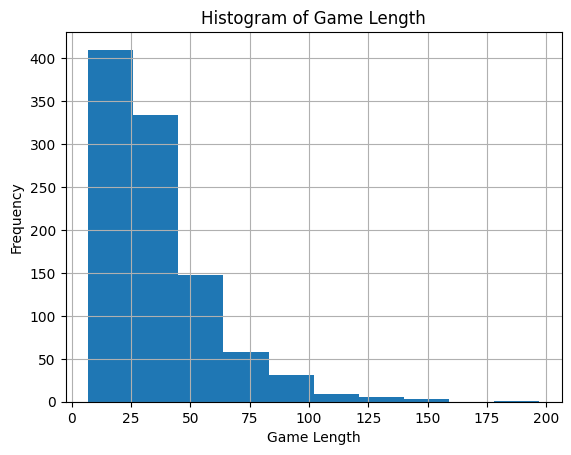

In [57]:
import matplotlib.pyplot as plt

def histogram_plot():
  data['Game Length'].hist(bins=10)
  plt.title('Histogram of Game Length')
  plt.xlabel('Game Length')
  plt.ylabel('Frequency')
  plt.show()

histogram_plot()


In [28]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 5.1 MB/s eta 0:00:00


In [44]:
import os
from groq import Groq
from google.colab import userdata

GROQ_API_KEY = userdata.get('GROQ_API_KEY')

client = Groq(
    api_key = GROQ_API_KEY
)

prompt = f"Given the summary statistics of game data (Game Number vs. Game Length), generate a descriptive analysis and insights based on patterns such as averages, trends, and anomalies not more than 200 words:\n{data_summary}"

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": prompt,
        }
    ],
    model="llama-3.3-70b-versatile",
)

summary = chat_completion.choices[0].message.content
print(chat_completion.choices[0].message.content)


The game data analysis reveals that the average game length is 35.41 minutes, with a standard deviation of 23.41 minutes, indicating moderate variability. The median game length is 30 minutes, suggesting that most games last around this duration. The data is somewhat symmetric, with the 25th percentile at 19 minutes and the 75th percentile at 45 minutes. Notably, the shortest game lasted 7 minutes, while the longest game lasted 197 minutes, highlighting a significant anomaly. Overall, the data suggests that while most games have a relatively consistent length, there are some extreme outliers that may warrant further investigation. The average game number is 500.5, indicating a balanced dataset.


In [27]:
# Tried using modeles via HuggingFace

from transformers import pipeline

model = pipeline("text-generation", model="EleutherAI/gpt-neo-2.7B", )

def generate_insights(data_summary):
    prompt = f"Given the summary statistics of game data (Game Number vs. Game Length), generate a descriptive analysis and insights based on patterns such as averages, trends, and anomalies:\n{data_summary}"
    response = model(prompt, max_length=200)
    return response[0]['generated_text']

data_summary = stats.to_string()
insights = generate_insights(data_summary)
print("Generated Insights:\n", insights)


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Insights:
 Given the summary statistics of game data (Game Number vs. Game Length), generate a descriptive analysis and insights based on patterns such as averages, trends, and anomalies:
       Game Number  Game Length
count  1000.000000  1000.000000
mean    500.500000    35.411000
std     288.819436    23.412608
min       1.000000     7.000000
25%     250.750000    19.000000
50%     500.500000    30.000000
75%     750.250000    45.000000
max    1000.000000   197.000000

## Chapter 3: Statistics on Games

### **Chapter Objectives**

• Understand basic statistics on data from games and apply


In [71]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import os
import textwrap
import matplotlib.pyplot as plt


def save_report_as_pdf(data, insights, filename='game_report.pdf'):
    c = canvas.Canvas(filename, pagesize=letter)

    c.setFont("Helvetica", 16)
    c.drawString(175, 750, f"Automated Data Analysis Report")

    c.setFont("Helvetica", 12)
    c.drawString(100, 720, f"Data Summary:")

    y_position = 680

    for line in data.describe().to_string().split('\n'):
        wrapped_lines = textwrap.wrap(line, width=85)
        for wrapped_line in wrapped_lines:
            c.drawString(100, y_position, wrapped_line)
            y_position -= 15

    y_position -= 20
    c.drawString(100, y_position, f"\n")

    y_position -= 20
    c.drawString(100, y_position, f"Data Visualization:")

    plt.figure(figsize=(5, 3))
    data['Game Length'].hist(bins=10)
    plt.title('Histogram of Game Length')
    plt.xlabel('Game Length')
    plt.ylabel('Frequency')
    plt.savefig("visualization.png", format='png', bbox_inches='tight')
    plt.close()

    c.drawImage("visualization.png", 100, y_position - 100, width=400, height=300)

    y_position -= 120
    c.drawString(100, y_position, f"Insights:")
    y_position -= 20


    wrapped_lines = textwrap.wrap(insights, width=85)
    for line in wrapped_lines:
        c.drawString(100, y_position, line)
        y_position -= 15

    c.save()


insights = """
The game data analysis reveals that the average game length is 35.41 minutes, with a standard deviation of 23.41 minutes, indicating moderate variability. The median game length is 30 minutes, suggesting that most games last around this duration. The data is somewhat symmetric, with the 25th percentile at 19 minutes and the 75th percentile at 45 minutes. Notably, the shortest game lasted 7 minutes, while the longest game lasted 197 minutes, highlighting a significant anomaly. Overall, the data suggests that while most games have a relatively consistent length, there are some extreme outliers that may warrant further investigation. The average game number is 500.5, indicating a balanced dataset.
"""


save_report_as_pdf(data, insights, filename="game_report.pdf")


from google.colab import files
files.download('game_report.pdf')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>